In [2]:
import os
import typing
from dataclasses import dataclass

import glob
import re

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
import base64
from io import BytesIO

from airium import Airium

In [49]:
@dataclass
class InferenceAttributes():
    n_iter: int
    mode: str
    lr: float
    bs: int
    p: float

def _read_file(
    file_name,
    random_pattern = r"\.\/out\/inference.random.(?P<n_iter>\d+).(?P<mode>(final)|(validation)).LR(?P<lr>.*)_BS(?P<bs>.*)_P(?P<p>.*).csv",
    deterministic_pattern = r"\.\/out\/inference.(?P<mode>(final)|(validation)).LR(?P<lr>.*)_BS(?P<bs>.*)_P(?P<p>.*).csv"
):
    if attributes := re.match(random_pattern, file_name):
        attributes = attributes.groupdict()
    elif attributes := re.match(deterministic_pattern, file_name):
        attributes = attributes.groupdict()
        attributes["n_iter"] = 0
    else:
        raise ValueError()
    
    df = pd.read_csv(file_name)
    return df, InferenceAttributes(**attributes)

@dataclass
class PerplexityStatsOutput():
    d_mean: float
    d_q1: float
    d_q2: float
    d_q3: float
    c_pearson: float
    distplot: str
    jointplot: str

def get_encoded_density(base, mutated, d):
    g = sns.displot(x=d, kind="kde", fill=True)
    tmpfile = BytesIO()
    plt.savefig(tmpfile, format='png')
    d_encoded = base64.b64encode(tmpfile.getvalue()).decode('utf8')
    plt.close()

    g = sns.jointplot(x=base, y=mutated, kind="kde")
    tmpfile = BytesIO()
    plt.savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf8')
    plt.close()

    return d_encoded, encoded

def perplexity_stats(file_name):
    df, attributes = _read_file(file_name)
    base, mutated = df["perplexity_src"], df["perplexity_mut"]
    c_pearson = sp.stats.pearsonr(base, mutated ).statistic

    d = base - mutated 
    d_q1, d_q2, d_q3 = [(d).quantile(q) for q in [0.25, 0.50, 0.75]]
    d_mean = (d).mean()

    distplot, jointplot = get_encoded_density(base, mutated, d)

    out = PerplexityStatsOutput(d_mean, d_q1, d_q2, d_q3, c_pearson, distplot, jointplot)
    return out, attributes

@dataclass
class MutationStatsOutput():
    n_unpaired_sequences: int
    nodes: typing.List[str]
    edges: typing.List[typing.Tuple[str, str]]
    adjacency_matrix: np.ndarray
    top_from: typing.List[str]
    top_to: typing.List[str]
    top_edges: typing.List[typing.Tuple[str, str, float]]
    clustermap: str

def get_encoded_clustermap(adjacency_matrix, nodes):
    g = sns.clustermap(adjacency_matrix, xticklabels=nodes, yticklabels=nodes)

    tmpfile = BytesIO()
    plt.savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf8')
    plt.close()
    return encoded

def mutation_stats(file_name, base_file_name, n_top_nodes=10, n_top_edges=20):
    df, attributes = _read_file(file_name)
    base_df = pd.read_csv(base_file_name)

    sequences = df.iloc[:, -1].to_list()
    base_sequences = base_df.iloc[:, -1].to_list()
    assert len(sequences) == len(base_sequences)

    paired_sequences = [(base_sequence, sequence) for base_sequence, sequence in zip(base_sequences, sequences) if len(base_sequence) == len(sequence)]
    n_unpaired_sequences = len(sequences) - len(base_sequences)

    nodes = list(set([el for seq in sequences for el in seq] + [el for seq in base_sequences for el in seq]))
    edges = [(base_sequence[i], sequence[i]) for base_sequence, sequence in paired_sequences for i in range(len(sequence))]

    adjacency_matrix = {from_node: {to_node: 0 for to_node in nodes} for from_node in nodes}
    for from_node, to_node in edges: adjacency_matrix[from_node][to_node] += 1
    adjacency_matrix = np.array([list(row.values()) for row in adjacency_matrix.values()])
    adjacency_matrix = adjacency_matrix / adjacency_matrix.sum(axis=1)[:, None]
    np.fill_diagonal(adjacency_matrix, 0)

    top_from = [nodes[i] for i in np.argsort(adjacency_matrix.sum(axis=1))[-n_top_nodes:]][::-1]
    top_to = [nodes[i] for i in np.argsort(adjacency_matrix.sum(axis=0))[-n_top_nodes:]][::-1]
    top_edges = list(zip(list(adjacency_matrix.flatten().argsort()[-n_top_edges:] // len(adjacency_matrix)), list(adjacency_matrix.flatten().argsort()[-n_top_edges:] % len(adjacency_matrix))))[::-1]
    top_edges = [(nodes[from_node], nodes[to_node], adjacency_matrix[from_node, to_node ]) for from_node, to_node in top_edges]

    clustermap = get_encoded_clustermap(adjacency_matrix, nodes)

    return MutationStatsOutput(n_unpaired_sequences, nodes, edges, adjacency_matrix, top_from, top_to, top_edges, clustermap), attributes

@dataclass
class ThermophilicityStatsOutput():
    pairplot: str

def thermophilicity_stats(thermophilicity_stats_file):
    df = pd.read_csv(thermophilicity_stats_file)
    g = sns.pairplot(df)
    tmpfile = BytesIO()
    plt.savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf8')
    plt.close()
    return ThermophilicityStatsOutput(encoded)

def summary(file_name, base_file_name, thermophilicity_stats_file=None):
    p_stats, attributes = perplexity_stats(file_name)
    m_stats, _ = mutation_stats(file_name, base_file_name)
    t_stats = None
    if thermophilicity_stats_file is not None:
        t_stats = thermophilicity_stats(thermophilicity_stats_file)

    a = Airium()
    a('<!DOCTYPE html>')

    with a.html(lang="en"):
        with a.head():
            a.meta(charset="utf-8")
            a.meta(name="viewport", content="width=device-width, initial-scale=1")
            a.title(_t="Mutator Analysis")
            a.link(href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.1/dist/css/bootstrap.min.css", rel="stylesheet", integrity="sha384-4bw+/aepP/YC94hEpVNVgiZdgIC5+VKNBQNGCHeKRQN+PtmoHDEXuppvnDJzQIu9", crossorigin="anonymous")
        
        with a.body():
            with a.h1():
                a(f"Mutator Analysis")

            with a.div(klass="accordion"):
                with a.div(klass="accordion-item"):
                    with a.h2(klass="accordion-header"):
                        with a.button(klass="accordion-button", type="button", data__bs__toggle="collapse", data__bs__target="#panelsStayOpen-collapseOne", aria__expanded="true", aria__controls="panelsStayOpen-collapseOne"):
                            a("Inference Model")
                    with a.div(id="panelsStayOpen-collapseOne", klass="accordion-collapse collapse show"):
                        with a.div(klass="accordion-body"):
                            with a.ul(klss="list-group list-group-flush"):
                                with a.li(klass="list_group-item"):
                                    a(f"Model selection: {attributes.mode}")
                                with a.li(klass="list_group-item"):
                                    a(f"Learning rate: {attributes.lr}")
                                with a.li(klass="list_group-item"):
                                    a(f"Batch size: {attributes.bs}")
                                with a.li(klass="list_group-item"):
                                    a(f"Mask rate: {attributes.p}")
                                if attributes.n_iter != 0:
                                    with a.li(klass="list_group-item"):
                                        a(f"Random inference  with {attributes.n_iter} iterations")

                with a.div(klass="accordion-item"):
                    with a.h2(klass="accordion-header"):
                        with a.button(klass="accordion-button", type="button", data__bs__toggle="collapse", data__bs__target="#panelsStayOpen-collapseTwo", aria__expanded="true", aria__controls="panelsStayOpen-collapseTwo"):
                            a("Perplexity Stats")
                    with a.div(id="panelsStayOpen-collapseTwo", klass="accordion-collapse collapse show"):
                        with a.div(klass="accordion-body"):
                            with a.table(klass="table"):
                                with a.thead():
                                    with a.tr():
                                        with a.th(scope="col"):
                                            a("Mean &#916;Perplexity")
                                        with a.th(scope="col"):
                                            a("Q1 &#916;Perplexity")
                                        with a.th(scope="col"):
                                            a("Q2 &#916;Perplexity")
                                        with a.th(scope="col"):
                                            a("Q3 &#916;Perplexity")
                                        with a.th(scope="col"):
                                            a("PCC")
                                with a.tbody():
                                    with a.tr():
                                        with a.td(scope="col"):
                                            a(f"{p_stats.d_mean:.3f}")
                                        with a.td(scope="col"):
                                            a(f"{p_stats.d_q1:.3f}")
                                        with a.td(scope="col"):
                                            a(f"{p_stats.d_q2:.3f}")
                                        with a.td(scope="col"):
                                            a(f"{p_stats.d_q3:.3f}")
                                        with a.td(scope="col"):
                                            a(f"{p_stats.c_pearson:.3f}")

                            with a.div(klass="container"):
                                with a.div(klass="row"):
                                    with a.div(klass="col-sm"):
                                        with a.h3():
                                            a("&#916;Perplexity Distribution")
                                        a.img(src=f"data:image/png;base64,{p_stats.distplot}", alt="", klass="img-fluid")
                                    with a.div(klass="col-sm"):
                                        with a.h3():
                                            a("Perplexity Distribution")
                                        a.img(src=f"data:image/png;base64,{p_stats.jointplot}", alt="", klass="img-fluid")

                with a.div(klass="accordion-item"):
                    with a.h2(klass="accordion-header"):
                        with a.button(klass="accordion-button", type="button", data__bs__toggle="collapse", data__bs__target="#panelsStayOpen-collapseThree", aria__expanded="true", aria__controls="panelsStayOpen-collapseThree"):
                            a("Mutation Stats")
                    with a.div(id="panelsStayOpen-collapseThree", klass="accordion-collapse collapse show"):
                        with a.div(klass="accordion-body"):
                            
                            with a.div(klass="alert alert-warning", role="alert"):
                                a(f"{m_stats.n_unpaired_sequences} sequences were not successfully paired...")
                            
                            with a.h3():
                                a("Top Mutated Amino Acids")
                            with a.table(klass="table"):
                                with a.thead():
                                    with a.tr():
                                        with a.th(scope="col"):
                                            a("#")
                                        for i in range(len(m_stats.top_from)):
                                            with a.th(scope="col"):
                                                a(str(i))
                                with a.tbody():
                                    with a.tr():
                                        with a.th(scope="col"):
                                            a("from")
                                        for i in range(len(m_stats.top_from)):
                                            with a.td(scope="col"):
                                                a(m_stats.top_from[i])
                                    with a.tr():
                                        with a.th(scope="col"):
                                            a("to")
                                        for i in range(len(m_stats.top_to)):
                                            with a.td(scope="col"):
                                                a(m_stats.top_to[i])

                            with a.h3():
                                a("Top Mutations")
                            with a.table(klass="table table-sm table-striped"):
                                with a.thead():
                                    with a.tr():
                                        with a.th(scope="col"):
                                            a("from")
                                        with a.th(scope="col"):
                                            a("to")
                                        with a.th(scope="col"):
                                            a("P(t|f)")
                                with a.tbody():
                                    for from_node, to_node, p in m_stats.top_edges:
                                        with a.tr():
                                            with a.td(scope="col"):
                                                a(from_node)
                                            with a.td(scope="col"):
                                                a(to_node)
                                            with a.td(scope="col"):
                                                a(f"{p:.3f}")

                            with a.h3():
                                a("Mutations Clustermap")
                            a.img(src=f"data:image/png;base64,{m_stats.clustermap}", alt="", klass="img-fluid")

                with a.div(klass="accordion-item"):
                    with a.h2(klass="accordion-header"):
                        with a.button(klass="accordion-button", type="button", data__bs__toggle="collapse", data__bs__target="#panelsStayOpen-collapseFour", aria__expanded="true", aria__controls="panelsStayOpen-collapseFour"):
                            a("Thermophilicity Analysis")
                    with a.div(id="panelsStayOpen-collapseFour", klass="accordion-collapse collapse show"):
                        with a.div(klass="accordion-body"):
                            a("Content")

            a.script(src="https://cdn.jsdelivr.net/npm/bootstrap@5.3.1/dist/js/bootstrap.bundle.min.js", integrity="sha384-HwwvtgBNo3bZJJLYd8oVXjrBZt8cqVSpeBNS5n7C8IVInixGAoxmnlMuBnhbgrkm", crossorigin="anonymous")

    html = str(a)
    html = html.replace("__", "-")
    return html, p_stats, m_stats, t_stats, attributes

def multiple_summary(file_name_template, base_file_name, out_dir="./html"):
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)
    

    columns = ["Model selection", "Learning rate", "Batch size", "Mask rate", "N. iterations", "Mean &#916;Perplexity", "Q1 &#916;Perplexity", "Q2 &#916;Perplexity", "Q3 &#916;Perplexity", "PPC"]
    values = []
    links = []

    for file_name in glob.glob(file_name_template):
        html, p_stats, m_stats, t_stats, attributes = summary(file_name, base_file_name)

        values.append([attributes.mode, attributes.lr, attributes.bs, attributes.p, attributes.n_iter, p_stats.d_mean, p_stats.d_q1, p_stats.d_q2, p_stats.d_q3, p_stats.c_pearson])
        links.append(os.path.join("./", os.path.basename(file_name)[:-4] + ".html"))

        with open(os.path.join(out_dir, os.path.basename(file_name)[:-4] + ".html"), "w") as f:
            f.write(html)

    values_df = pd.DataFrame(values, columns=columns)
    values_df = values_df.astype({"Model selection":str, "Learning rate":float, "Batch size":int, "Mask rate":float, "N. iterations":int, "Mean &#916;Perplexity":float, "Q1 &#916;Perplexity":float, "Q2 &#916;Perplexity":float, "Q3 &#916;Perplexity":float, "PPC":float})
    values_df = values_df.sort_values(["Mask rate", "Model selection", "Learning rate", "Batch size", "N. iterations"])
    values = values_df.values

    a = Airium()
    a('<!DOCTYPE html>')

    with a.html(lang="en"):
        with a.head():
            a.meta(charset="utf-8")
            a.meta(name="viewport", content="width=device-width, initial-scale=1")
            a.title(_t="Mutator Analysis")
            a.link(href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.1/dist/css/bootstrap.min.css", rel="stylesheet", integrity="sha384-4bw+/aepP/YC94hEpVNVgiZdgIC5+VKNBQNGCHeKRQN+PtmoHDEXuppvnDJzQIu9", crossorigin="anonymous")
        
        with a.body():
            with a.h1():
                a(f"Mutator Analysis")

            with a.h2():
                a(f"Summary")

            with a.table(klass="table table-sm table-striped"):
                with a.thead():
                    with a.tr():
                        with a.th(scope="col"):
                            a("#")
                        for el in columns:
                            with a.th(scope="col"):
                                a(el)

                with a.tbody():
                    for i, row in enumerate(values):
                        with a.tr():
                            with a.th(scope="col"):
                                with a.a(href=f"{links[i]}"):
                                    a(i)
                            for el in row:
                                with a.td(scope="col"):
                                    a(el) if not isinstance(el, float) else a(f"{el:.3f}")

            a.script(src="https://cdn.jsdelivr.net/npm/bootstrap@5.3.1/dist/js/bootstrap.bundle.min.js", integrity="sha384-HwwvtgBNo3bZJJLYd8oVXjrBZt8cqVSpeBNS5n7C8IVInixGAoxmnlMuBnhbgrkm", crossorigin="anonymous")
                            
    html = str(a)
    html = html.replace("__", "-")
    with open(os.path.join(out_dir, "index.html"), "w") as f:
        f.write(html)

    with open(os.path.join(out_dir, "index.tex"), "w") as f:
        f.write(values_df.to_latex(float_format="{:.4f}".format))

    return values, values_df

In [50]:
html, p_stats, m_stats, t_stats, attributes = summary("./out/inference.random.10.final.LR0.001_BS512_P0.15.csv", "./data/_nt_test.csv", thermophilicity_stats_file="./out/inference.random.10.final.LR0.001_BS512_P0.15.stats.csv")

/home/agiottonini/miniconda3/envs/mes2therm/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [39]:
with open("test.html", "w") as f:
    f.write(html)

In [63]:
t_stats.df

,n_mutations,ddmut_prediction,maestro_score,maestro_dscore,maestro_ddg
0,5,2.93,3.417347,-0.027595,0.959611
1,3,0.69,-4.436604,-0.478164,-1.056886
2,15,-1.72,-3.808360,0.158941,0.051977
3,4,1.56,-5.426136,-1.245603,-1.607726
4,10,-0.24,-3.865104,-0.421359,-0.766166
...,...,...,...,...,...
94,10,0.15,-2.952852,0.509450,2.498212
95,14,-1.15,-2.965289,-0.559938,-0.414899
96,20,1.86,-9.246575,-0.342454,0.167120
97,6,1.91,-4.712158,-0.513955,-0.489527


/home/agiottonini/miniconda3/envs/mes2therm/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


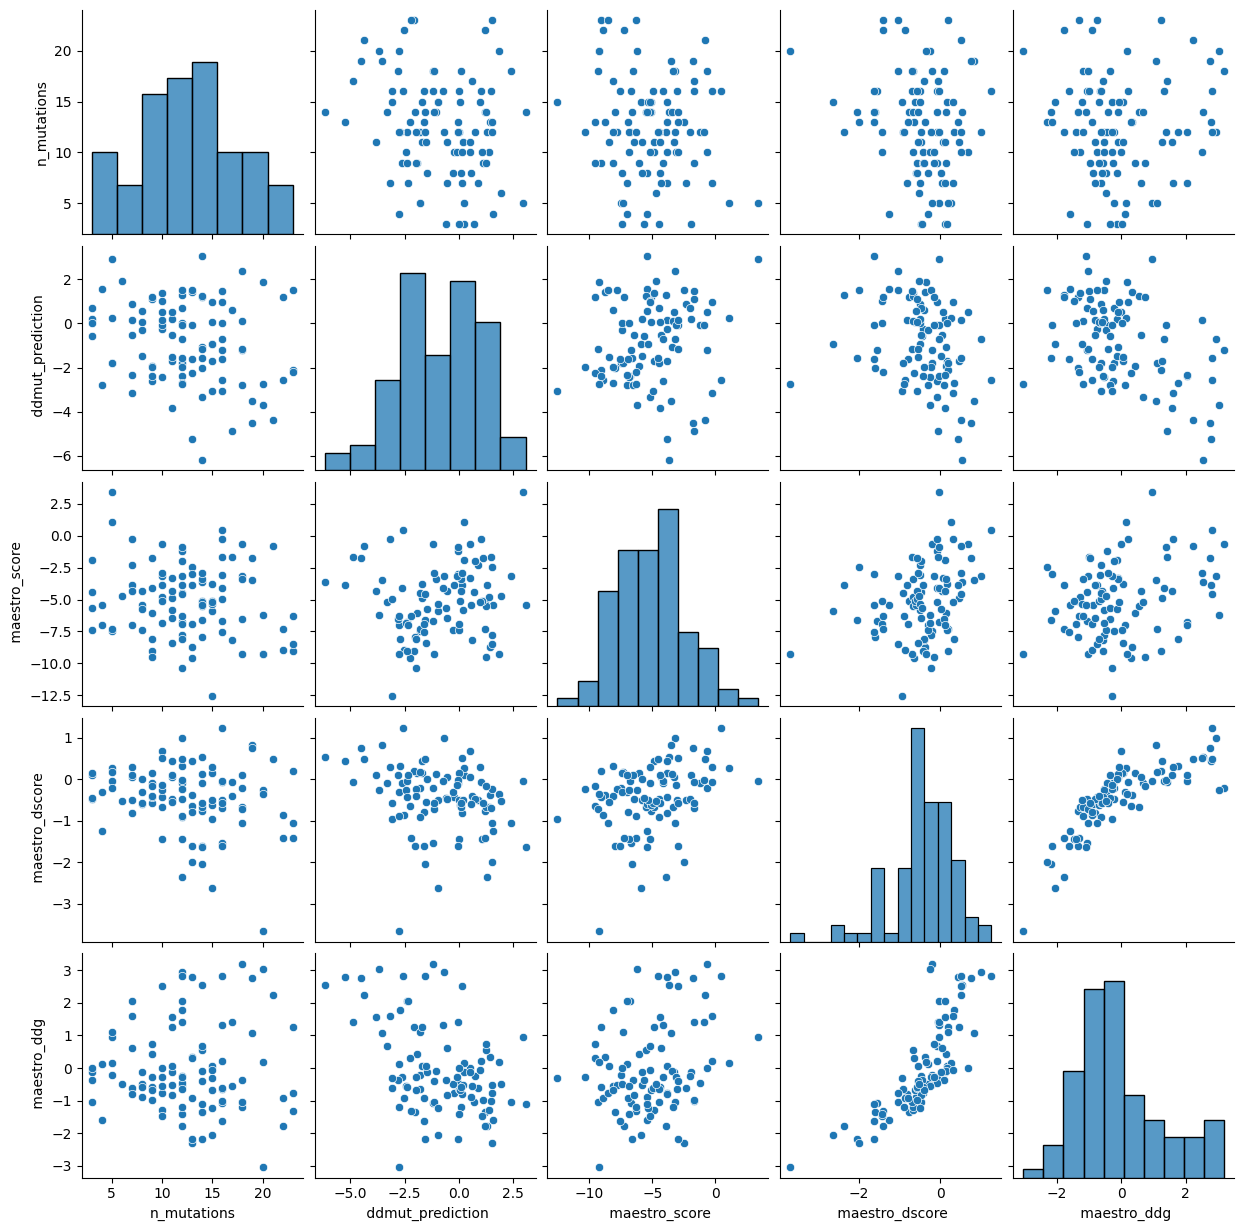